# Quantum Machine Learning Demo
## Illustrative example using Support Vector Machines and Quantum Kernels

Lead author: <br>
Dr. Stefan Kister<br>
IBM Quantum Ambassador, IBM DACH - Düsseldorf <br>

Created initially Stefan Kister and Patrick Bigge (Corporate Student, IBM DACH - Ehningen): January 2022<br>
Updated by Stefan Kister, Christoffer Jensen (IBM Denmark - Brondby), Eric Michiels (IBM Quantum Technical Ambassador, IBM Belgium-Luxembourg - Brussels): June 2022 

Updated by Stefan Kister to new Qiskit runtime primitive design: November 2022 <br>
Updates by Stefan Kister to information on sources and corrections of images: December 2022 <br>
Updates by Stefan Kister, August 2023: <br>
    - consider updates of runtime primitives and implemented necessary code changes  <br>
    - change to torch backend for keras core (https://keras.io/keras_core/)  <br>
    - consider change of qiskit_algorithms as an independent package (pip install necessary) <br>




## Content

1. Machine Learning Introduction
2. Brief overview of SVM theory
3. Classical applications of SVMs today
4. Practical demonstration of SVMs **[CLASSIC]**
5. ML with Quantum - Qiskit Machine Learning Module
6. Brief overview of QSVM classification theory
7. Quantum Kernel Estimation
8. The hybrid process between quantum and classical computers
9. Practical demonstration of QSVMs **[QUANTUM]**
10. Cases where QSVMs (might) provide an advantage

---

## 1. Machine Learning Introduction

![ML_learning_paradigms](./images/01_ML_learning_paradigms.png)

![ML_problem_types](./images/02_ML_problem_types.png)

## 2. Brief overview of SVM theory

*For a more detailed introduction to SVM theory, please refer to this in-depth [lecture notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf).*<br>

![classification](./images/03_classification.png)

![classic_kernel](./images/04_classic_kernel.png)

## 3. Classical applications of SVMs today

Before we dig into the details, let's first get an idea where Support Vector Machines (SVMs) are being used today.

| use case                   | description         | classification    |
|----------------------------|---------------------|-------------------|
| facial recognition         | emotions expressed  | happy <-> sad     |
| cancer diagnosis/prognosis | based on image data | malign <-> benign |
| text classification        | filter              | no spam <-> spam  |
| surface recognition        | -                   | smooth <-> gritty |

Additionally SVMs are being used in the fields of speech recognition, news categorization and handwriting recognition.<br>
There are even more use cases than the ones listed here, which proves the diversity of possible application fields.

---


 ## 4. Practical demonstration of SVMs **[CLASSIC]**

In [1]:
import numpy as np

import torch
import keras_core as keras
import matplotlib.pyplot as plt
%matplotlib inline
import functools
import pandas as pd

from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session
from qiskit.primitives import Sampler
import qiskit_algorithms
#from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import IBMQ, Aer

Using PyTorch backend.


#### License: Yann LeCun and Corinna Cortes hold the copyright of MNIST dataset, which is a derivative work from original NIST datasets. MNIST Data is used under the terms of the [Creative Commons Attribution-Share Alike 3.0 license](https://creativecommons.org/licenses/by-sa/3.0/) and is loaded from the [Keras website](https://keras.io/api/datasets/mnist/).

In [2]:
# loading data - MNIST dataset: https://keras.io/api/datasets/mnist/
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train_flattened = x_train.reshape(len(x_train), 28*28)
x_test_flattened = x_test.reshape(len(x_test), 28*28)

y_train = np.append(y_train,y_test)
x_test = np.append(x_train_flattened, x_test_flattened,axis=0)

x_train_pd = pd.DataFrame(x_test)
y_labels = pd.Series(y_train)

x_attributes = x_train_pd

In [3]:
x_train# LABELS = [1,2,3,5,7,9]
LABELS = [1,9]
# LABELS = range(0,10)
num_labels = len(LABELS)
bool_keep_labels = []
for i in range(num_labels):
    bool_keep_labels.append(y_labels == LABELS[i])

# bitwise or comparison to filter for selected labels
labels_filtered = y_labels[functools.reduce(lambda y1, y2: y1 | y2, bool_keep_labels)]
# filter for samples which correspond to specified labels
attributes_filtered = x_attributes.filter(items=labels_filtered.index, axis=0)

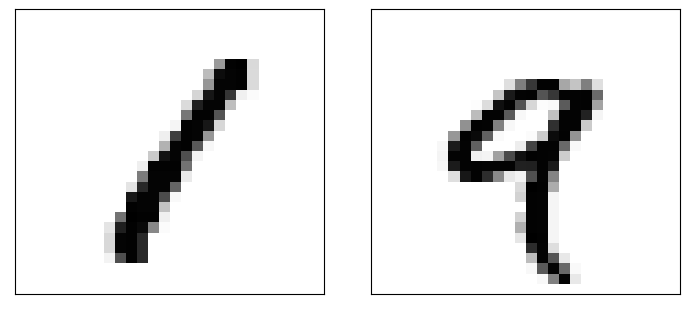

In [4]:
fig = plt.figure(figsize = (7,3.2))

for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    img = attributes_filtered.filter(items=labels_filtered[labels_filtered == LABELS[i]].index, axis=0).iloc[0].values.reshape(28,28)
    ax.imshow(img, cmap="Greys", aspect="auto")

plt.tight_layout(w_pad=3.0)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(attributes_filtered, labels_filtered, test_size=0.20, random_state=42)

In [6]:
%%capture
svclassifier_rbf = SVC(kernel="rbf", max_iter=10)
svclassifier_rbf.fit(x_train, y_train)

In [7]:
rbf_prediction = svclassifier_rbf.predict(x_test)
print("Support Vector Machine accuracy using a RBF Kernel\n\n" + classification_report(y_test, rbf_prediction))

Support Vector Machine accuracy using a RBF Kernel

              precision    recall  f1-score   support

           1       0.57      0.61      0.59      1592
           9       0.51      0.46      0.49      1375

    accuracy                           0.54      2967
   macro avg       0.54      0.54      0.54      2967
weighted avg       0.54      0.54      0.54      2967



## 5. ML with Quantum - Qiskit Machine Learning Module

**_Qiskit Architecture_**<br>
![qiskit_architecture](./images/05a_qiskit-architecture-overview.svg)<br>
**_Qiskit Machine Learning Module_**<br>
<br>
<br>
![qiskit_qml_module](./images/05b_qiskit_qml_module.png)

## 6. Brief overview of QSVM classification theory

![quantum_kernel](./images/06_quantum_kernel.png)

### Quantum Kernels

In this section we will show one can define and derive the quantum computational analog of the classical kernel matrix we saw above, and in a later section we will use this method to compute a quantum kernel, that we will use to perform classification on the hand-written integers in the MNIST dataset. We will for the sake of simplicity only work with pure quantum states in this demonstration.


Obtaning the quantum analogue of the kernel matrix can be divided into two steps: 
1. The classical input data need to be mapped onto the quantum computer, creating a unique quantum state for each classical data vector.
2. A quantity describing the degree of similarity between different quantum states must be defined, where we will use the quantum state fidelity.

### Encoding

Before we can commence, we will need to "transfer" our classical information onto the quantum computer and thereby encode our classical data onto quantum states existing in a quantum feature space.
This can be done by defining a quantum feature map $\mathbf{x} \rightarrow |{\phi (\mathbf{x})>}$, which maps our classical input data $\mathbf{x}$ onto the quantum state $|{\phi (\mathbf{x})>}$.
The operations that we can perform on a quantum computer are described by unitary operators, so we are looking for a unitary operator that can uniquely encode our information onto a quantum state. 
Such a quantum feature map can be realized as a parameterized quantum circuit defined by $U(\mathbf{x})$ acting on the all zeros quantum state as $ U (\mathbf{x}) | {0^{\otimes n}}\rangle = | \phi (\mathbf{x}) \rangle$ , where $n$ is the number of qubits in our system and is chosen such that it coincides with dimension of our classical input data.

Now that we have encoded our classical data onto a quantum feature space.

#### Simple Example
Here's a short visualization on the bloch sphere regarding the P-gate. The first P-gate's factor for pi was in the range [0,2] with a step size of 0.01. The second P-gate's factor for pi was constant at 1.

Below is an example for the circuit where both factors were at 1.

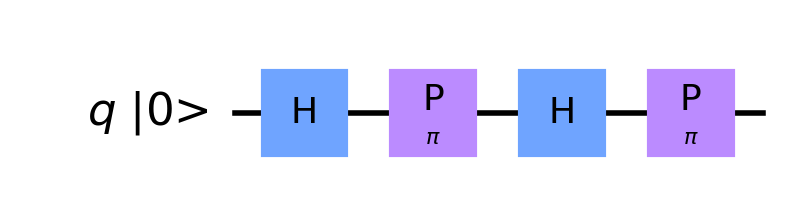

In [8]:
from qiskit import QuantumCircuit
import math

qc = QuantumCircuit(1)
qc.h(0)
qc.p(1*math.pi,0)
qc.h(0)
qc.p(1*math.pi,0)

qc.draw("mpl", initial_state=True, scale=2)

Here is the visualization of the shifting state, using the specified range, on the bloch sphere:


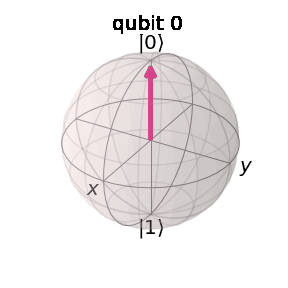

In [9]:
import base64
from IPython import display

def show_gif(fname):
    with open(fname, "rb") as fd:
        b64 = base64.b64encode(fd.read()).decode("ascii")
    return display.HTML(f"<center><img src='data:image/gif;base64,{b64}' /></center>")

show_gif("images/07_bloch_animation.gif")

## 7. Quantum Kernel Estimation

Recall that the matrix entries of the classical kernel was defined as $K_{ij} = K(\mathbf{x}_i, \mathbf{x}_j) = \phi (\mathbf{x}_i)^T \phi (\mathbf{x}_j)$, where the quantity $K_{ij}$ is a real-valued number which could be thought of intuitively as a measure of the similarity between two vectors.

However, we are now interested in finding the similarity between two quantum states, to this end we will use the quantum state fidelity, which for a pair of pure quantum states $|{\psi_i}>, |{\psi_j}>$ is defined as
$$
 F(|{\psi_i}>,|{\psi_j}>) = |<{\psi_j}|{\psi_i}>|^2.
$$

The state fidelity is a real-valued number between $0$ and $1$, which effectively gives a description of how similar the two quantum states are, with $0$ meaning that the states are completely distinct, and $1$ meaning that they are the same,  and we will therefore choose the quanutm state fidelity as our quantum kernel entries and set $K_{ij}=F(|{\psi_i}>,|{\psi_j}>)$.
Using our definition of the encoding map $U(x)$, we can derive an easy expression for our state fidelity by considering 

$$
K(\mathbf{x}_i, \mathbf{x}_j) = F(|{\psi_i}>,|{\psi_j}>)= |<{\psi_j}|{\psi_i}>|^2 = |<{0^{\otimes n}}|U^\dagger(x_j) U(x_i) |{0^{\otimes n}}>|^2
$$

From this expression we notice that in order to determine the entries of the quantum kernel matrix, we simply have to compute the squared modulus of the expectation value of the operator $U^\dagger(x_j) U(x_i)$. Due to the very simple form of the equation, we can simply apply the two unitary operators to an $n$-qubit system initiated in the all zeros state, then apply the two unitary operations as quantum circuits, and then measure the probability of getting the all zeros state.



Note that the unitarity of the operators means that $U^\dagger(x)U(x)=I$, which imply that $U^\dagger(x)=U^{-1}(x)$ and we can therefore think of the action of $U^\dagger (x_j)U(x_i)$ as first encoding the classical data onto a quantum state $U(x_i)|{0^{\otimes n}}>=|{\psi(x_i)}>$ and then seeing how well the inverse operation $U^\dagger (x_j)$ maps $|{\psi(x_i)}>$ back to $|{0^{\otimes n}}>$. It follows naturally that the diagonal entries equal $1$, and that the off-diagonal elements are symmetric about the diagonal, i.e. $K(\mathbf{x}_i, \mathbf{x}_j) = K(\mathbf{x}_j, \mathbf{x}_i)$.

![qke](./images/08_qke.png)

The figure above depicts the quantum circuit implementation of the formula $U^\dagger(\mathbf{x_j}) U(\mathbf{x_i})|{0^{\otimes n}}>$ for $n=5$, followed by measurements of all the qubits. 
Due to the probablistic nature of the measurement readouts, this circuit should be run for a suitable amount of shots until one obtains satisfactory convergence of the probablity distributions.

The quantum kernel matrix contains all the state fidelity of all the possible combinations of quantum feature states. The quantum kernel matrix is visaluized in the figure below for a system of 50 different quantum states as a 50 by 50 grid, where each point correspond to a matrix entry and where the color correspond to the value of the state fidelities, where a darker green correspond to a fidelity closer to one and white correspond to a state fidelity of zero. Recall that the diagonal entries are equal to unity, and notice that the grid is symmetric about the diagonal.

![kernel_matrix_column_similarity](./images/09_kernel_matrix_column_similarity.png)

In the figure below, we illustrate the action of applying the unitary operator $U(\mathbf{x_i})$ (orange arrow) followed by the $U^\dagger(\mathbf{x_j})$ (cyan arrow), where the two operations result in the final state indicated by the green arrow, for three different scenarios, (left) the inputs states are the same $x_i=x_j$ which results in the identity operation, (middle) the effect of $U^\dagger(x_j)$ almost reverse the action of $U(x_i)$ and (right) the action of $U^\dagger(x_j)$ rotates the state $U(\mathbf{x_i})|{0^n}>$ even further towards the excited state.

![similarity_rotations](./images/10_similarity_rotations.png)

### Challenges for QKE & current solutions

Due to the hardware limitations of systems with a small number of qubits into which we can encode our classical input data, we will have to reduce the dimensions of the classical input vectors. In order to lose as little information as possible, we will perform a principal component analysis of the input data to find the vector entries that carry the most valuable information. 

Another significant obstacle is that the current quantum computers are very noisy, this noise will greatly restrict the circuit depths that can produce viable results and even when restricting the circuit depths, the noise will still greatly affect the model accuracy that we can reliably obtain.

## 8. The hybrid process between quantum and classical computers

As discussed in the previous chapters quantum computers can estimate a kernel which then can be used for classification purposes by a SVM.

Before the algorithm can predict new unseen data points it requires some training. This follows the described steps for QKE where the training kernel is optimized iteratively using the evaluation of classical computers.

Once an optimal circuit has been discovered it is possible to use the estimated kernel from the QKE algorithm. 

So overall in the process quantum only plays a role when it comes to the kernel. The rest is done using classical computers and algorithms. This is the near term application of quantum computing in most cases: a hybrid process between classical and quantum.<br>
Classical computing has had more time to develop efficient and accurate algorithms which is why (for the most part) quantum computing currently targets specific parts of algorithm optimization rather than the development of completely new ones.

Introduced in [Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), a proposed model of computation is to integrate near-term Quantum Processing Units (QPU) into classical computing architecture. The results of each of the respective task is transfered between the CPU and QPU. The image below illustrates such a model for the case of SVMs. 

![Hybrid-Quantum-SVM](./images/qsvm.png)


Thus, in detail we can describe the full support vector machine algorithm with quantum kernel estimation (SVM & QKE), with training and testing phases, like it is shown in the paper on "[A rigorous and robust quantum speed-up in supervised machine learning](https://arxiv.org/pdf/2010.02174.pdf)"

1. SVM & QKE **[Training]**
    1. Set all $K_{ii} = 1$ since the fidelity(similarity) between them is at the maximum possible value (1)
    2. Iterate over all (*-> half because of the symmetry*) $K_{ij}$, for each specific $ij$ pair repeat the circuit $R$ times (measurement shots), set the mean of the measured probability for $| {0^{\otimes n}}\rangle$ as the kernel matrix entry **[QKE]**
    3. Complete the kernel matrix via the diagonality ($K = \frac{1}{2}(K_{half} + \mathcal{1_{m \times m}})$) $\quad \mathcal{1}$ having all ones as entries
    4. Insert the estimated kernel into the dual formula (*Chapter 4*) **[SVM]**
    5. Return set of $\alpha$ (*$\alpha_i$ corresponding to support vectors $\neq 0$*)
    
<br>

2. SVM & QKE **[Testing]** <br>
    Given a new example $\mathbf{x}$ & a training set $\{ (\mathcal{x}_i \mathcal{y}_i) \} ^m_{i=1}$ & training parameters $\alpha_i , ... , \alpha_j$
    1. Repeat the circuit $R$ times (measurement shots)
    2. Measure the mean probability for $| {0^{\otimes n}}\rangle$ denoted as $p$ across all circuit cycles
    3. $t = \sum^m_{i=1} \alpha_i \mathcal{y}_i \cdot \frac{p+1}{2}$
    4. return $sign(t)$

## 9. Practical demonstration of QSVMs **[QUANTUM]**

### Quantum Feature Maps

Below you can see that if both vectors (or each entry in this case) are identical we receive the identity matrix (for each qubit) which also explains why we measure for the all zero qubit state  |0⊗𝑛⟩  at the end of the circuit (since if both blocks form the identity matrix  𝐼  we measure the state we initialized the circuit with).

#### Pauli-Z Feature Maps

A relatively simple quantum feature map can be derived from the feature map construction proposed in [https://arxiv.org/pdf/1804.11326.pdf], where they start out by considering a unitary $\mathcal{U}_{\Phi}(\mathbf{x}) = U_{\Phi(\mathbf{x})}H^{\otimes n} U_{\Phi(\mathbf{x})}H^{\otimes n}$ where $H^{\otimes n}$ is the conventional hamadard gate acting on $n$-qubits and $$U_{\Phi(\mathbf{x})} = \exp(i\sum_{S\subseteq [n]} \phi_S(\mathbf{x}) \prod_{i \in S}P_i),$$

where $\mathbf{x}\in \mathbb{R}^n$, $ S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, $P_i \in \{ I, X, Y, Z \}$ is a one of the Pauli matrices, and where $\phi$ is a non-linear map from a classical vector $\mathbf{x}$ to a quantum state $|{\psi{(\mathbf{x})}}>$ given by

$\phi_S(\vec{x}) = \begin{cases}
            x_0 \text{ if } k = 1 \\
            \prod_{j \in S} (\pi - x_j) \text{ otherwise }.
            \end{cases}$
            
This is a very general formulation and we will therefore limit our attention to the case of only Pauli-Z matrices, i.e. $P_i = Z_i$. 

If we further restrict ourselves to the cases of either $|S|\leq 1$ or $|S| \leq 2$, then the unitary $U_{\Phi(\mathbf{x})}H^{\otimes n}$ corresponds to the qiskit circuit library functions 'ZFeatureMap' and 'ZZFeatureMaps' with a single repetition, respectively. 

[https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html#qiskit.circuit.library.ZFeatureMap].
The motivation for choosing to restrict the weight of the Pauli-operators comes from the desire to limit the circuit depth and it is therefore favorable to limit oneself to two-qubit gates as three- and higher-qubit gates greatly increase the circuit depth. 

For the present case we will restrict our attention to the 'ZZFeatureMap' for which the non-linear map is defined by $\phi(x)=x$ and $\phi(x,y) = (\pi -x)(\pi -y)$. 


In the code block below we implement a ZZFeatureMap from the qiskit circuit library on a 3-qubit register, where we have chosen to use two repetitions of the circuit with linear entanglement.

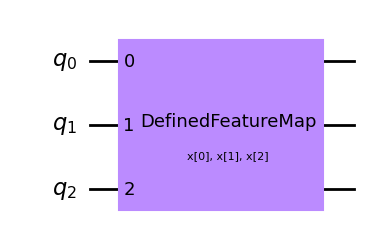

In [10]:
# On basis of PauliFeatureMap an designed feature map is created, in this example a ZZFeatureMap is created which is also availbe in Qiskit 
feature_map = PauliFeatureMap(feature_dimension=3, reps=1, entanglement="full", alpha=2.0, paulis=["Z", "ZZ"], data_map_func=None, parameter_prefix='x', insert_barriers=True, name='DefinedFeatureMap')
feature_map.draw("mpl")



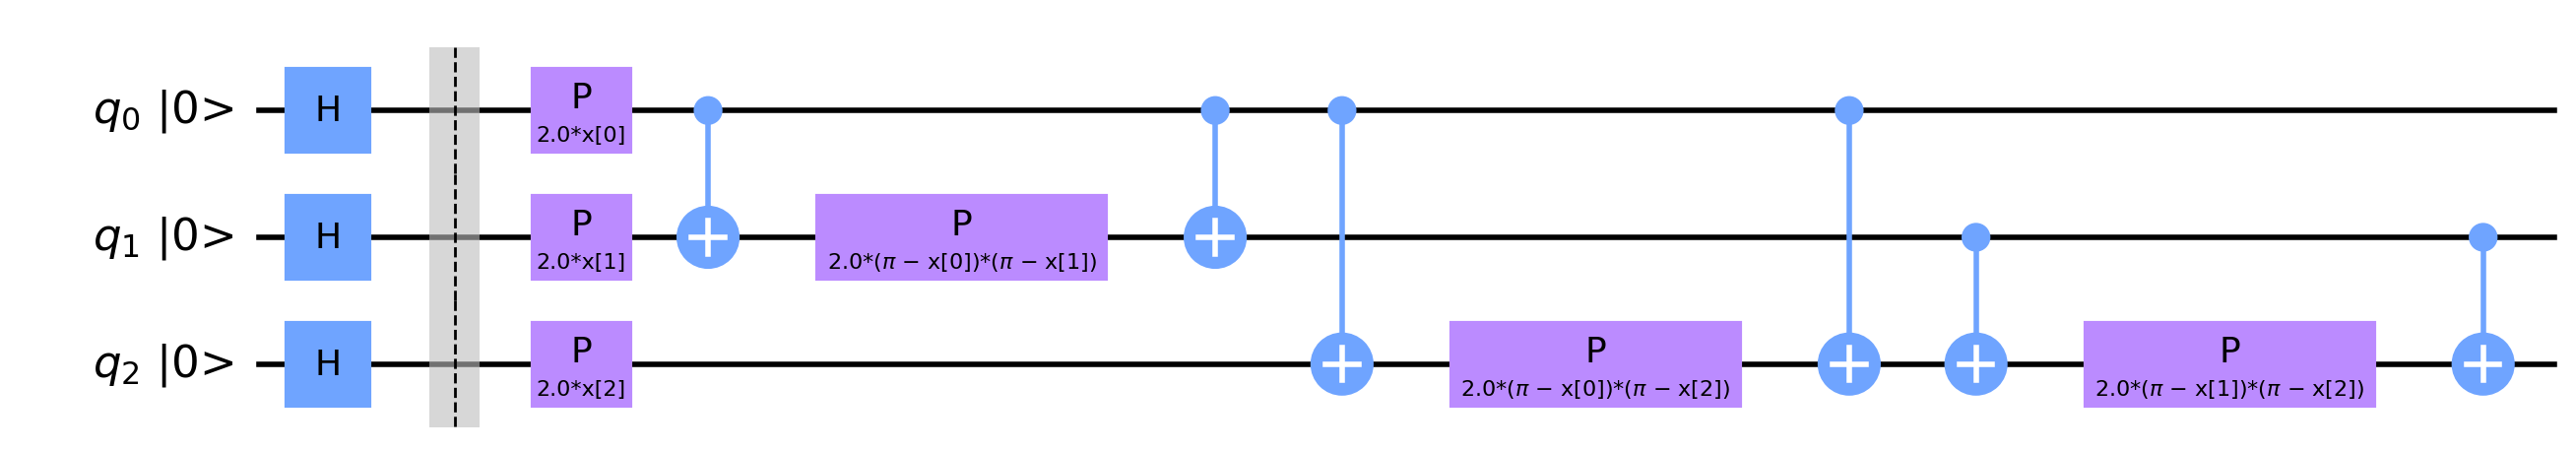

In [11]:
# look at the details of the defined feature map
feature_map.decompose().draw("mpl", initial_state=True, scale=2)

There are also even more feature maps accessible in Qiskit, such as `EfficientSU2` or `RealAmplitudes`, and you can of course create your own feature map circuit. However to keep the demo brief those are left out here. Please refer to [the qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html) for further information.

### Algorithms

In summuary, the quantum support-vector machine with quantum kernel estimation consists of the following steps:

- First the classical input data is encoded onto quantum feature space via a quantum feature map $\mathcal{U}(x)$.
- The quantum kernel is obtained by quantum kernel estimation, where the kernel matrix entries are the probabilities of measuring the all zeros state from $\mathcal{U}^\dagger(x_j) \mathcal{U}(x_i) |{0^n}>$.
- Lastly, we implement the obtained quantum kernel in a classical SVM algorithm.

### Compute a quantum kernel to use with classcial SVC workflow

#### Setting up Qiskit Runtime service either in IBM Quantum or IBM Cloud
However, in this demo we use the Sampler primitive with the Statevector Simulator. For that reason the two following code snippets have been set into raw format.

#### Data preparation for quantum

In [12]:
# need to re-size the data sample for training and test to a suitable size for statevector simulator.
train_sample_size = 0.00676
test_sample_size = 0.00167

x_train, x_test, y_train, y_test = train_test_split(attributes_filtered, labels_filtered, train_size=train_sample_size, test_size=test_sample_size, random_state=algorithm_globals.random_seed)

In [13]:
SAMPLE_SIZE = len(x_train)
TEST_SIZE = len(x_test)
print("SAMPLE SIZE =", SAMPLE_SIZE, "=> this is representing also the dimension of the kernel matrix for training which is", SAMPLE_SIZE,"x",SAMPLE_SIZE )
print("TEST SIZE =", TEST_SIZE, "=> this is representing also the dimension of the kernel matrix for testing which is", TEST_SIZE,"x",SAMPLE_SIZE )

SAMPLE SIZE = 100 => this is representing also the dimension of the kernel matrix for training which is 100 x 100
TEST SIZE = 25 => this is representing also the dimension of the kernel matrix for testing which is 25 x 100


In [14]:
# Standardize
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

# Reduce dimensions
N_DIM = 2
pca = PCA(n_components=N_DIM)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

# Normalize
mms = MinMaxScaler((-np.pi, np.pi))
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

print(f"The leftover information content by reducing the dataset to {N_DIM} dimensions is {round(sum(pca.explained_variance_ratio_)*100, 2)}%.")

The leftover information content by reducing the dataset to 2 dimensions is 26.34%.


#### Creating Feature Map and define quantum kernel circuit

In [15]:
from qiskit.algorithms.state_fidelities import ComputeUncompute

reps=1 
entanglement="full"
alpha=2.0
paulis=["Y"]
data_map_func=None
parameter_prefix='x'
insert_barriers=None
name='DesignedFeatureMap'

feature_map = PauliFeatureMap(feature_dimension=N_DIM, reps=reps, entanglement=entanglement, alpha=alpha, paulis=paulis, data_map_func=data_map_func, parameter_prefix=parameter_prefix, insert_barriers=insert_barriers, name=name)

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

Quantum Kernel Estimate Circuit


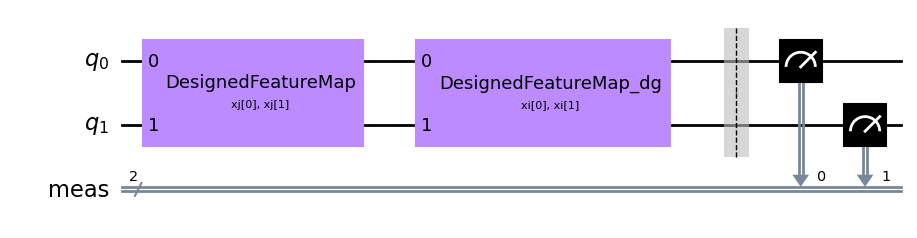

In [16]:
# Draw Quantum Kernel Estimate circuit

parameter_prefix='xj'
fm_xj = PauliFeatureMap(feature_dimension=N_DIM, reps=reps, entanglement=entanglement, alpha=alpha, paulis=paulis, data_map_func=data_map_func, parameter_prefix=parameter_prefix, insert_barriers=insert_barriers, name=name)
parameter_prefix='xi'
fm_xi = PauliFeatureMap(feature_dimension=N_DIM, reps=reps, entanglement=entanglement, alpha=alpha, paulis=paulis, data_map_func=data_map_func, parameter_prefix=parameter_prefix, insert_barriers=insert_barriers, name=name)


fm_deg = fm_xi.inverse()
qke_circuit = fm_xj.compose(fm_deg)
qke_circuit.measure_all()
#qke_circuit.decompose().draw('mpl')
print("Quantum Kernel Estimate Circuit")
qke_circuit.draw('mpl')

#### Calculating Kernel Matrix for Training and Testing

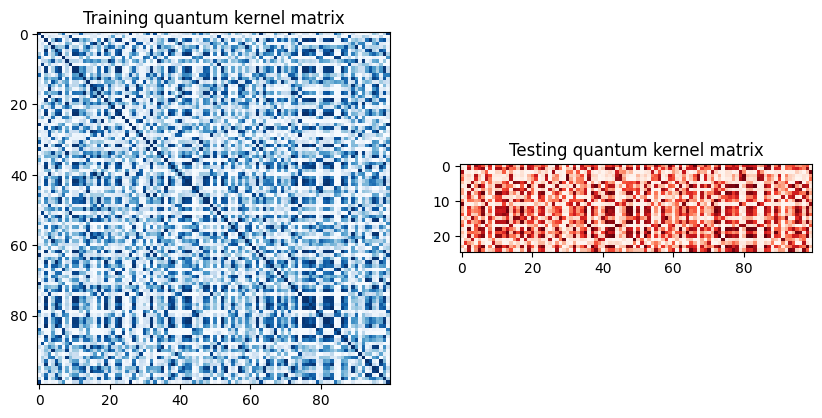

In [17]:
qkmatrix_train = qkernel.evaluate(x_vec=x_train)
qkmatrix_test = qkernel.evaluate(x_vec=x_test, y_vec=x_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(qkmatrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training quantum kernel matrix")

axs[1].imshow(np.asmatrix(qkmatrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing quantum kernel matrix")

plt.show()

#### Running SVC with precomputed Quantum Kernel

In [18]:
qsvc = SVC(kernel="precomputed")

qsvc.fit(qkmatrix_train,(y_train.iloc[:len(x_train)]))
qke_prediction = qsvc.predict(qkmatrix_test)


print("Support Vector Machine accuracy using a Quantum Kernel calculated by Quantum Kernel Estimation\n\n")
print(classification_report(y_test.iloc[:len(x_test)], qke_prediction))

Support Vector Machine accuracy using a Quantum Kernel calculated by Quantum Kernel Estimation


              precision    recall  f1-score   support

           1       0.79      0.94      0.86        16
           9       0.83      0.56      0.67         9

    accuracy                           0.80        25
   macro avg       0.81      0.75      0.76        25
weighted avg       0.81      0.80      0.79        25



## 10. Cases where QSVMs (might) provide an advantage 



Quantum computing provides many promising features such as exponentially large Hilbert spaces along with powerful algorithms which are intractable on classical hardware.

The mission of finding real-world applications for which quantum algorithms provide an advantage over classical computing is currently a very active research area.
This is however especially challenging in the present where we do not have access to fault-tolerant quantum computing, and where we instead are limited to shallow and narrow quantum circuits on very noisy hardware.


In order for the quantum support-vector machine algorithms to provide an improvement over classical compute, the quantum kernels should be hard to estimate classically and they should be able to solve a problem better (whether this is in terms of time, memeory, test accuracy, etc.) than what is possible with classical computation.


It was shown in "*[A rigorous and robust quantum speed-up in supervised machine learning](https://arxiv.org/pdf/2010.02174.pdf)*" that a quantum computational speed-up can be achieved by using a support-vector machine algorithm together with a quantum kernel which they obtain by a procedure called quantum kernel estimation, that will be described later.

In the article "*[Covariant quantum kernels for data with group structure](https://arxiv.org/pdf/2105.03406.pdf)*" they aim to find a class of learning problems for which QKE is suitable, together with providing a genaralization of the result of "*[A rigorous and robust quantum speed-up in supervised machine learning](https://arxiv.org/pdf/2010.02174.pdf)*".

In [19]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright